In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import datetime


In [9]:
# Verileri yükle
df_0507 = pd.read_csv("accidents_2005_to_2007.csv", parse_dates=['Date'], dayfirst=True, low_memory=False)
df_0911 = pd.read_csv("accidents_2009_to_2011.csv", parse_dates=['Date'], dayfirst=True, low_memory=False)
df_1214 = pd.read_csv("accidents_2012_to_2014.csv", parse_dates=['Date'], dayfirst=True, low_memory=False)


# Birleştir
df = pd.concat([df_0507, df_0911, df_1214], ignore_index=True)
df.shape


(1504150, 33)

In [11]:
df.info()
df.describe()
df.isnull().sum()  # eksik değerler
df['Accident_Severity'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504150 entries, 0 to 1504149
Data columns (total 33 columns):
 #   Column                                       Non-Null Count    Dtype         
---  ------                                       --------------    -----         
 0   Accident_Index                               1504150 non-null  object        
 1   Location_Easting_OSGR                        1504049 non-null  float64       
 2   Location_Northing_OSGR                       1504049 non-null  float64       
 3   Longitude                                    1504049 non-null  float64       
 4   Latitude                                     1504049 non-null  float64       
 5   Police_Force                                 1504150 non-null  int64         
 6   Accident_Severity                            1504150 non-null  int64         
 7   Number_of_Vehicles                           1504150 non-null  int64         
 8   Number_of_Casualties                         1504150

Accident_Severity
3    1280205
2     204504
1      19441
Name: count, dtype: int64

In [13]:
# Eksik değer sayısı ve yüzdesi
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_summary = pd.DataFrame({'Eksik Değer Sayısı': missing, 'Eksik Yüzde (%)': missing_percent})
missing_summary[missing_summary['Eksik Değer Sayısı'] > 0].sort_values(by='Eksik Yüzde (%)', ascending=False)


,Eksik Değer Sayısı,Eksik Yüzde (%)
Junction_Detail,1504150,100.000000
Carriageway_Hazards,1476900,98.188346
Special_Conditions_at_Site,1467568,97.567929
Junction_Control,602835,40.078117
LSOA_of_Accident_Location,108238,7.195958
Did_Police_Officer_Attend_Scene_of_Accident,2922,0.194263
Road_Surface_Conditions,1958,0.130173
Weather_Conditions,126,0.008377
Time,117,0.007778
Location_Easting_OSGR,101,0.006715


In [15]:
# Eksik yüzdesi %95 üzeri olan sütunları otomatik silecek şekilde ayarlayalım:
def drop_high_missing_cols(df, threshold=0.95):
    missing_ratio = df.isnull().mean()
    cols_to_drop = missing_ratio[missing_ratio > threshold].index
    return df.drop(columns=cols_to_drop)

# Junction_Control gibi sütunları 'Unknown' etiketiyle dolduralım
def fill_categorical_with_unknown(df, colname):
    df[colname] = df[colname].fillna('Unknown')
    return df

# Diğer düşük eksikler için basit doldurma: mod/mean
def fill_remaining_missing(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == 'object':
                df[col] = df[col].fillna(df[col].mode()[0])
            else:
                df[col] = df[col].fillna(df[col].mean())
    return df

# Uygulama (örnek olarak df_1214 üzerinde gösteriyorum):
df_1214 = drop_high_missing_cols(df_1214)
df_1214 = fill_categorical_with_unknown(df_1214, 'Junction_Control')
df_1214 = fill_remaining_missing(df_1214)


In [17]:
# İşlem öncesi eksik değer oranları
print("İşlem Öncesi Eksik Değer Oranları:")
print(df_1214.isnull().mean().sort_values(ascending=False).head(10))

# Eksik değer işlemleri
df_1214 = drop_high_missing_cols(df_1214)
df_1214 = fill_categorical_with_unknown(df_1214, 'Junction_Control')
df_1214 = fill_remaining_missing(df_1214)

# İşlem sonrası eksik değer oranları
print("\nİşlem Sonrası Eksik Değer Oranları:")
print(df_1214.isnull().mean().sort_values(ascending=False).head(10))


İşlem Öncesi Eksik Değer Oranları:
Accident_Index                                 0.0
Location_Easting_OSGR                          0.0
LSOA_of_Accident_Location                      0.0
Did_Police_Officer_Attend_Scene_of_Accident    0.0
Urban_or_Rural_Area                            0.0
Road_Surface_Conditions                        0.0
Weather_Conditions                             0.0
Light_Conditions                               0.0
Pedestrian_Crossing-Physical_Facilities        0.0
Pedestrian_Crossing-Human_Control              0.0
dtype: float64

İşlem Sonrası Eksik Değer Oranları:
Accident_Index                                 0.0
Location_Easting_OSGR                          0.0
LSOA_of_Accident_Location                      0.0
Did_Police_Officer_Attend_Scene_of_Accident    0.0
Urban_or_Rural_Area                            0.0
Road_Surface_Conditions                        0.0
Weather_Conditions                             0.0
Light_Conditions                              

In [23]:
# Eksik değer sütunlarını belirle
missing_ratio = df.isnull().mean()
print(missing_ratio[missing_ratio > 0.01].sort_values(ascending=False))

# Çok eksik sütunları düşürelim (örneğin > %95 eksik olanlar)
df = df.drop(columns=missing_ratio[missing_ratio > 0.95].index)

# Örnek: Junction_Control sütunundaki eksikleri 'Unknown' ile doldur
if 'Junction_Control' in df.columns:
    df['Junction_Control'] = df['Junction_Control'].fillna('Unknown')

# Geri kalan eksikleri de uygun şekilde doldur
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].mean())

# Son durumu kontrol edelim
print(df.isnull().sum().sort_values(ascending=False).head(10))


Junction_Detail               1.000000
Carriageway_Hazards           0.981883
Special_Conditions_at_Site    0.975679
Junction_Control              0.400781
LSOA_of_Accident_Location     0.071960
dtype: float64
Accident_Index                                 0
Location_Easting_OSGR                          0
LSOA_of_Accident_Location                      0
Did_Police_Officer_Attend_Scene_of_Accident    0
Urban_or_Rural_Area                            0
Road_Surface_Conditions                        0
Weather_Conditions                             0
Light_Conditions                               0
Pedestrian_Crossing-Physical_Facilities        0
Pedestrian_Crossing-Human_Control              0
dtype: int64


In [29]:
# Zaten olmayan sütunları silmeye çalışma, hata vermesin diye errors='ignore ekleyelim
cols_to_drop = ['Junction_Detail', 'Carriageway_Hazards', 'Special_Conditions_at_Site']
df = df.drop(columns=cols_to_drop, errors='ignore')

# Geri kalan eksik değerleri dolduralım
df['Junction_Control'] = df['Junction_Control'].fillna('Unknown')
df['LSOA_of_Accident_Location'] = df['LSOA_of_Accident_Location'].fillna('Unknown')


In [33]:
def find_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers

numerical_cols = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']

for col in numerical_cols:
    outliers = find_outliers_iqr(df, col)
    print(f"{col} sütununda {len(outliers)} adet aykırı değer bulundu.")


Number_of_Vehicles sütununda 34081 adet aykırı değer bulundu.
Number_of_Casualties sütununda 350294 adet aykırı değer bulundu.
Speed_limit sütununda 0 adet aykırı değer bulundu.


In [35]:
def cap_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
    return data

df = cap_outliers(df, 'Number_of_Vehicles')
df = cap_outliers(df, 'Number_of_Casualties')


In [41]:
# Yıllara göre kaza sayısı
accidents_per_year = df['Date'].dt.year.value_counts().sort_index()

# 2005-2014 arası ve 2008'i de dahil edelim
years = list(range(2005, 2015))
accidents_per_year = accidents_per_year.reindex(years, fill_value=0)

print(accidents_per_year)


Date
2005    198735
2006    189161
2007    182115
2008         0
2009    163554
2010    154414
2011    151474
2012    179715
2013    138660
2014    146322
Name: count, dtype: int64


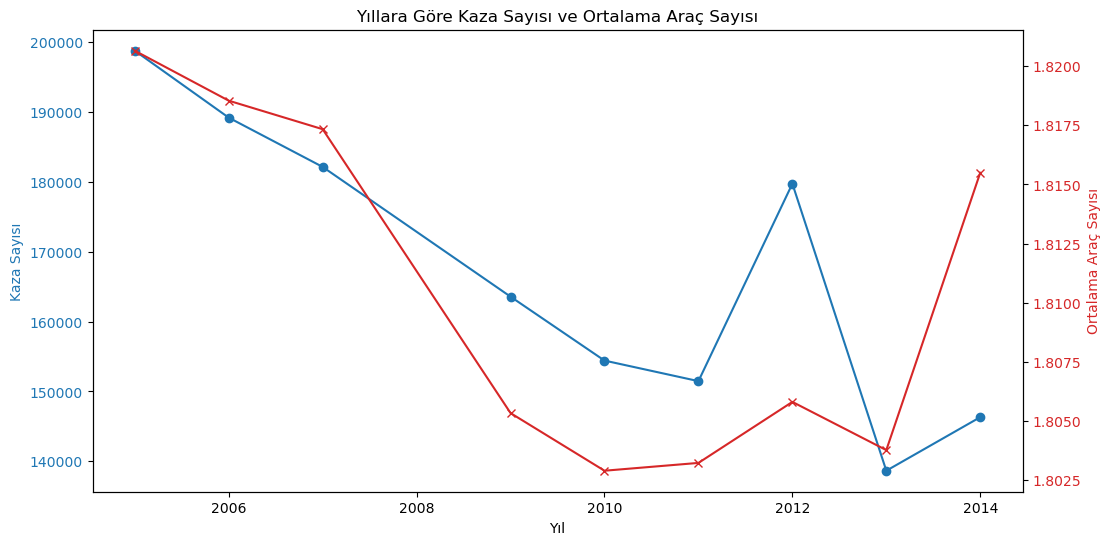

In [43]:
import matplotlib.pyplot as plt

# Yıllara göre kaza sayısı
accidents_per_year = df.groupby(df['Date'].dt.year).size()

# Yıllara göre ortalama araç sayısı
avg_vehicles_per_year = df.groupby(df['Date'].dt.year)['Number_of_Vehicles'].mean()

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:blue'
ax1.set_xlabel('Yıl')
ax1.set_ylabel('Kaza Sayısı', color=color)
ax1.plot(accidents_per_year.index, accidents_per_year.values, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Aynı grafik üzerinde ikinci y-ekseni
color = 'tab:red'
ax2.set_ylabel('Ortalama Araç Sayısı', color=color)
ax2.plot(avg_vehicles_per_year.index, avg_vehicles_per_year.values, color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Yıllara Göre Kaza Sayısı ve Ortalama Araç Sayısı')
plt.show()


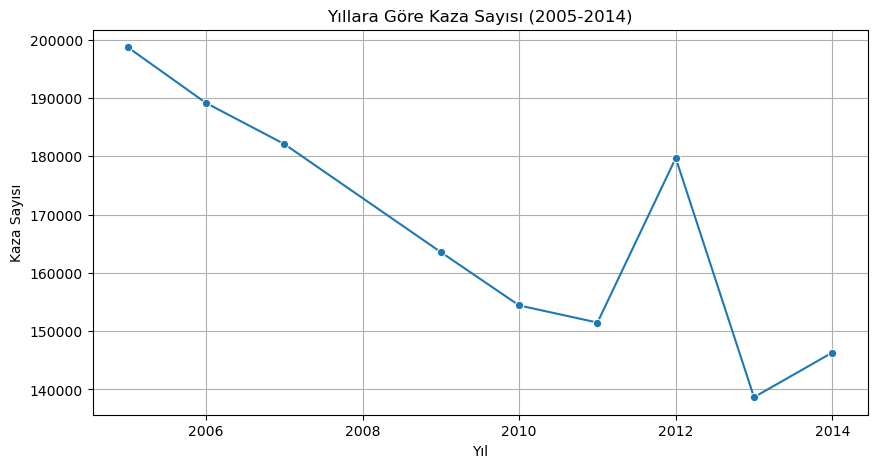

Yıllara Göre Kaza Sayısı:
 Date
2005    198735
2006    189161
2007    182115
2009    163554
2010    154414
2011    151474
2012    179715
2013    138660
2014    146322
Name: count, dtype: int64


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Yıllara göre kaza sayısı
accidents_per_year = df['Date'].dt.year.value_counts().sort_index()

plt.figure(figsize=(10,5))
sns.lineplot(x=accidents_per_year.index, y=accidents_per_year.values, marker='o')
plt.title('Yıllara Göre Kaza Sayısı (2005-2014)')
plt.xlabel('Yıl')
plt.ylabel('Kaza Sayısı')
plt.grid(True)
plt.show()

print("Yıllara Göre Kaza Sayısı:\n", accidents_per_year)


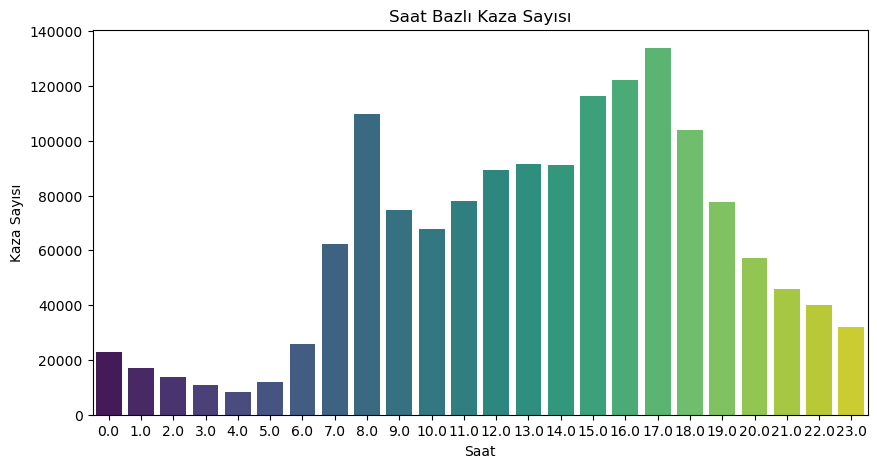

Saat Bazlı Kaza Sayısı:
 Hour
0.0      23025
1.0      16890
2.0      13618
3.0      10827
4.0       8347
5.0      12035
6.0      25832
7.0      62374
8.0     109622
9.0      74901
10.0     67895
11.0     78135
12.0     89225
13.0     91362
14.0     91262
15.0    116266
16.0    122131
17.0    133856
18.0    104085
19.0     77728
20.0     57216
21.0     45749
22.0     39891
23.0     31878
Name: count, dtype: int64


In [73]:
# Saat bilgisini ayıklama (Time sütunu 'HH:MM' formatında ise)
df['Hour'] = df['Time'].str.split(':').str[0].astype(float)

accidents_per_hour = df['Hour'].value_counts().sort_index()

plt.figure(figsize=(10,5))
sns.barplot(x=accidents_per_hour.index, y=accidents_per_hour.values, palette='viridis')
plt.title('Saat Bazlı Kaza Sayısı')
plt.xlabel('Saat')
plt.ylabel('Kaza Sayısı')
plt.show()

print("Saat Bazlı Kaza Sayısı:\n", accidents_per_hour)


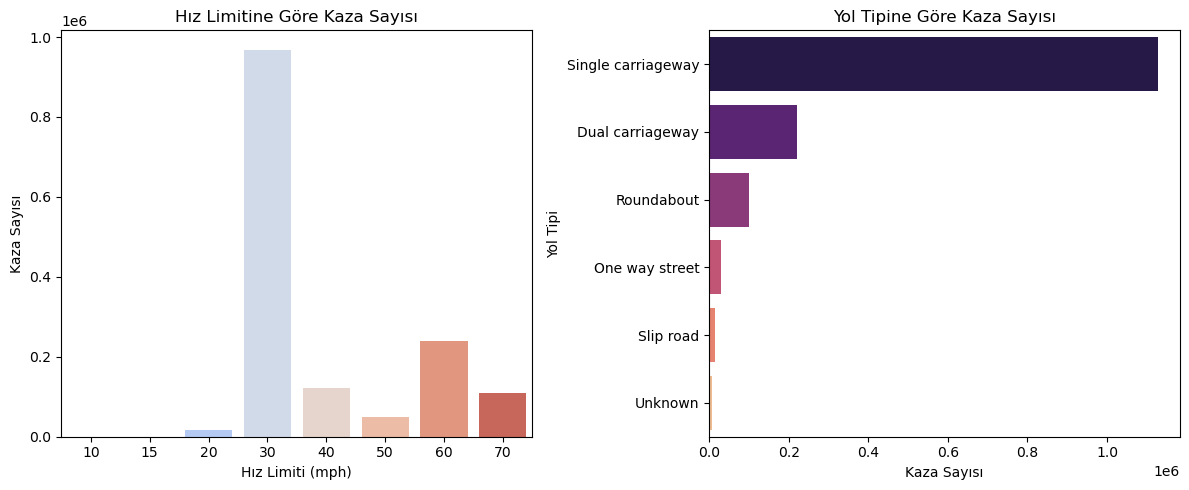

Hız Limitlerine Göre Kaza Sayısı:
 Speed_limit
10        14
15        10
20     17157
30    968284
40    122393
50     48790
60    238234
70    109268
Name: count, dtype: int64

Yol Tiplerine Göre Kaza Sayısı:
 Road_Type
Single carriageway    1126951
Dual carriageway       221741
Roundabout             100463
One way street          30981
Slip road               15668
Unknown                  8346
Name: count, dtype: int64


In [77]:
plt.figure(figsize=(12,5))

# Hız limitlerine göre kaza sayısı
plt.subplot(1,2,1)
speed_counts = df['Speed_limit'].value_counts().sort_index()
sns.barplot(x=speed_counts.index, y=speed_counts.values, palette='coolwarm')
plt.title('Hız Limitine Göre Kaza Sayısı')
plt.xlabel('Hız Limiti (mph)')
plt.ylabel('Kaza Sayısı')

# Yol tipine göre kaza sayısı
plt.subplot(1,2,2)
road_counts = df['Road_Type'].value_counts()
sns.barplot(y=road_counts.index, x=road_counts.values, palette='magma')
plt.title('Yol Tipine Göre Kaza Sayısı')
plt.xlabel('Kaza Sayısı')
plt.ylabel('Yol Tipi')

plt.tight_layout()
plt.show()

print("Hız Limitlerine Göre Kaza Sayısı:\n", speed_counts)
print("\nYol Tiplerine Göre Kaza Sayısı:\n", road_counts)


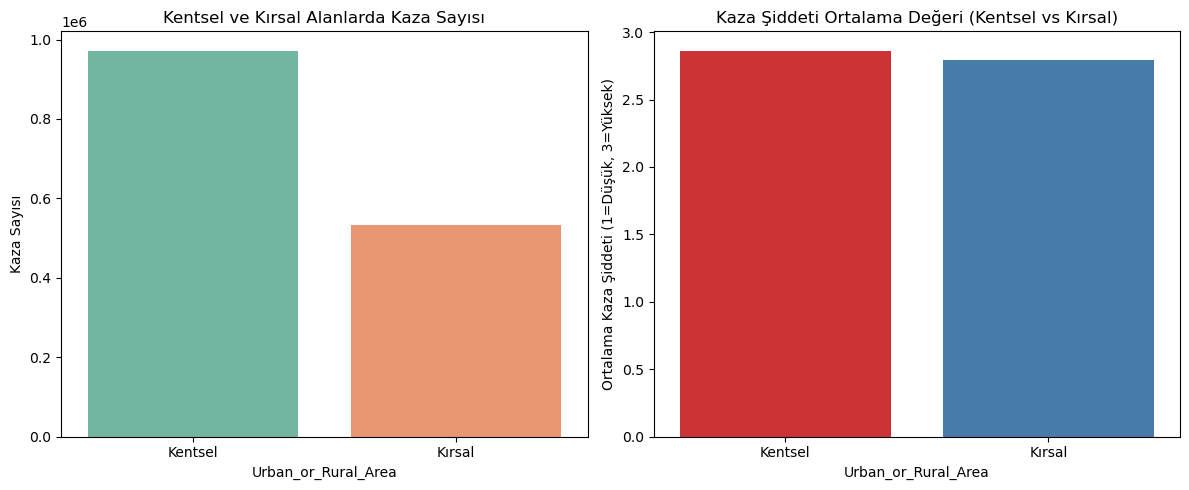

Kentsel ve Kırsal Alanlarda Kaza Sayısı:
 Urban_or_Rural_Area
Kentsel    972007
Kırsal     532011
Name: count, dtype: int64

Kentsel ve Kırsal Alanlarda Ortalama Kaza Şiddeti:
 Urban_or_Rural_Area
Kentsel    2.862637
Kırsal     2.793517
Name: Accident_Severity, dtype: float64


In [83]:
plt.figure(figsize=(12,5))

# Kaza sayısı
plt.subplot(1,2,1)
urban_rural_counts = df['Urban_or_Rural_Area'].map({1:'Kentsel', 2:'Kırsal'}).value_counts()
sns.barplot(x=urban_rural_counts.index, y=urban_rural_counts.values, palette='Set2')
plt.title('Kentsel ve Kırsal Alanlarda Kaza Sayısı')
plt.ylabel('Kaza Sayısı')

# Kaza şiddeti (ortalama şiddet)
severity_by_area = df.groupby(df['Urban_or_Rural_Area'].map({1:'Kentsel', 2:'Kırsal'}))['Accident_Severity'].mean()
plt.subplot(1,2,2)
sns.barplot(x=severity_by_area.index, y=severity_by_area.values, palette='Set1')
plt.title('Kaza Şiddeti Ortalama Değeri (Kentsel vs Kırsal)')
plt.ylabel('Ortalama Kaza Şiddeti (1=Düşük, 3=Yüksek)')

plt.tight_layout()
plt.show()

print("Kentsel ve Kırsal Alanlarda Kaza Sayısı:\n", urban_rural_counts)
print("\nKentsel ve Kırsal Alanlarda Ortalama Kaza Şiddeti:\n", severity_by_area)


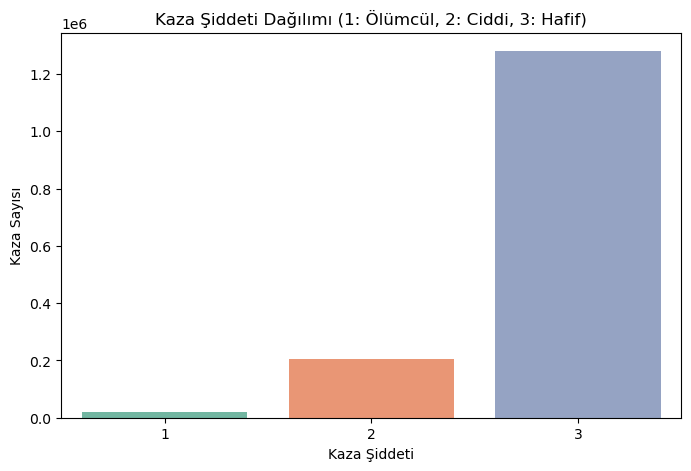

Kaza Şiddeti Sayıları:
 Accident_Severity
3    1280205
2     204504
1      19441
Name: count, dtype: int64 



In [81]:


plt.figure(figsize=(8,5))
sns.countplot(x='Accident_Severity', data=df, palette='Set2')
plt.title('Kaza Şiddeti Dağılımı (1: Ölümcül, 2: Ciddi, 3: Hafif)')
plt.xlabel('Kaza Şiddeti')
plt.ylabel('Kaza Sayısı')
plt.show()

print("Kaza Şiddeti Sayıları:\n", df['Accident_Severity'].value_counts(), "\n")


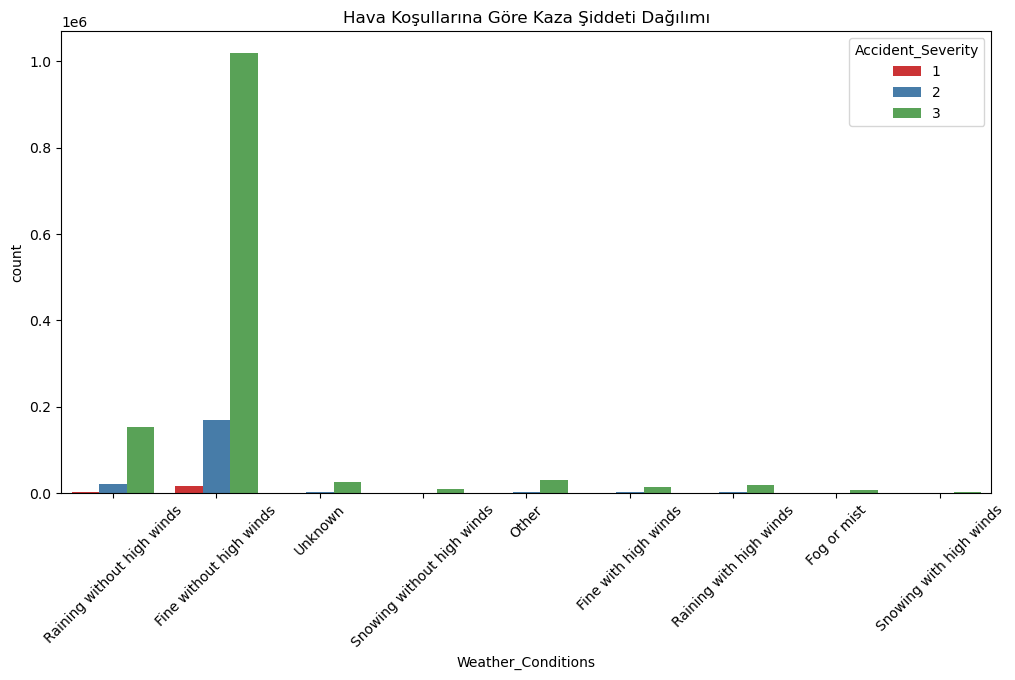

Hava Koşullarına Göre Kaza Sayısı:
 Weather_Conditions
Fine without high winds       1204069
Raining without high winds     177663
Other                           33503
Unknown                         28296
Raining with high winds         20813
Fine with high winds            18355
Snowing without high winds      11301
Fog or mist                      8190
Snowing with high winds          1960
Name: count, dtype: int64 



In [57]:

# 2a. Hava Durumu (Weather_Conditions)
plt.figure(figsize=(12,6))
sns.countplot(x='Weather_Conditions', hue='Accident_Severity', data=df, palette='Set1')
plt.title('Hava Koşullarına Göre Kaza Şiddeti Dağılımı')
plt.xticks(rotation=45)
plt.show()
print("Hava Koşullarına Göre Kaza Sayısı:\n", df['Weather_Conditions'].value_counts(), "\n")

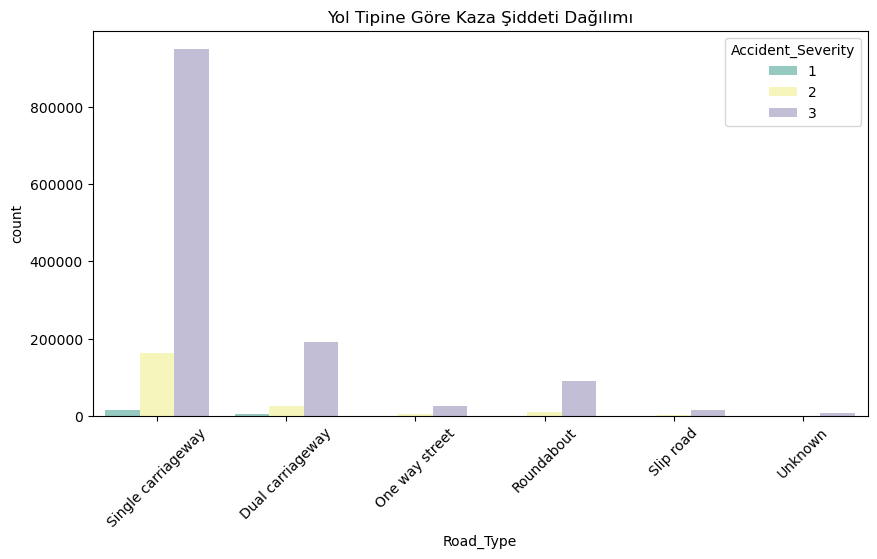

Yol Tiplerine Göre Kaza Sayısı:
 Road_Type
Single carriageway    1126951
Dual carriageway       221741
Roundabout             100463
One way street          30981
Slip road               15668
Unknown                  8346
Name: count, dtype: int64 



In [59]:
# 2b. Yol Tipi (Road_Type)
plt.figure(figsize=(10,5))
sns.countplot(x='Road_Type', hue='Accident_Severity', data=df, palette='Set3')
plt.title('Yol Tipine Göre Kaza Şiddeti Dağılımı')
plt.xticks(rotation=45)
plt.show()
print("Yol Tiplerine Göre Kaza Sayısı:\n", df['Road_Type'].value_counts(), "\n")

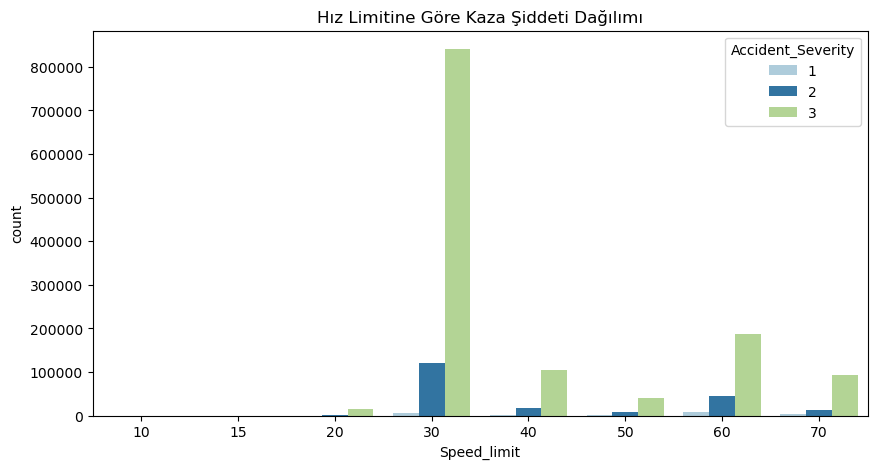

Hız Limitlerine Göre Kaza Sayısı:
 Speed_limit
30    968284
60    238234
40    122393
70    109268
50     48790
20     17157
10        14
15        10
Name: count, dtype: int64 



In [61]:
# 2c. Hız Limiti (Speed_limit)
plt.figure(figsize=(10,5))
sns.countplot(x='Speed_limit', hue='Accident_Severity', data=df, palette='Paired')
plt.title('Hız Limitine Göre Kaza Şiddeti Dağılımı')
plt.show()
print("Hız Limitlerine Göre Kaza Sayısı:\n", df['Speed_limit'].value_counts(), "\n")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20108\3155546433.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time'], errors='coerce').dt.hour


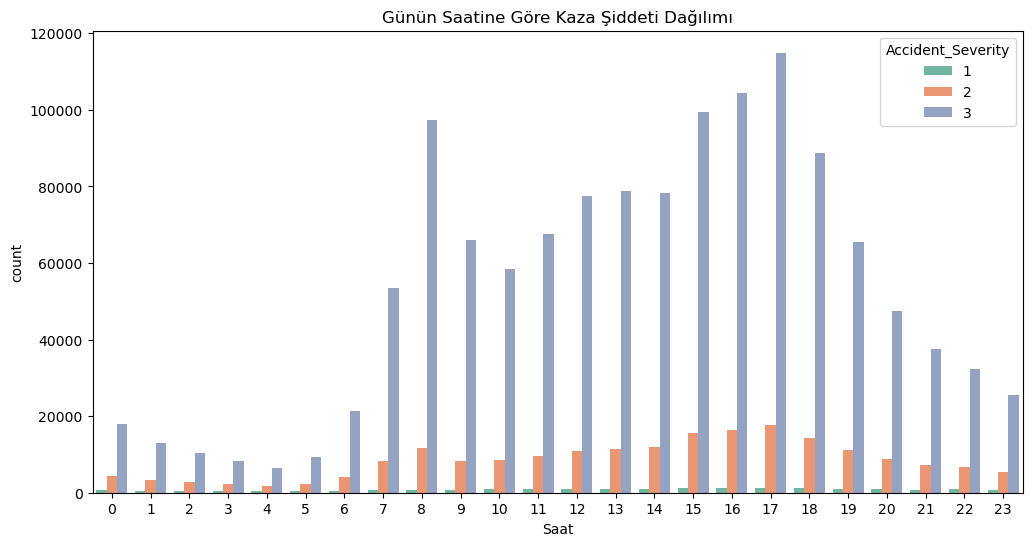

Saatlere Göre Kaza Sayısı:
 Hour
0      23025
1      16890
2      13618
3      10827
4       8347
5      12035
6      25832
7      62374
8     109622
9      74901
10     67895
11     78135
12     89225
13     91362
14     91262
15    116266
16    122131
17    133856
18    104085
19     77728
20     57216
21     45749
22     39891
23     31878
Name: count, dtype: int64 



In [63]:

# 2d. Günün Saati (Time)
df['Hour'] = pd.to_datetime(df['Time'], errors='coerce').dt.hour

plt.figure(figsize=(12,6))
sns.countplot(x='Hour', hue='Accident_Severity', data=df, palette='Set2')
plt.title('Günün Saatine Göre Kaza Şiddeti Dağılımı')
plt.xlabel('Saat')
plt.show()
print("Saatlere Göre Kaza Sayısı:\n", df['Hour'].value_counts().sort_index(), "\n")

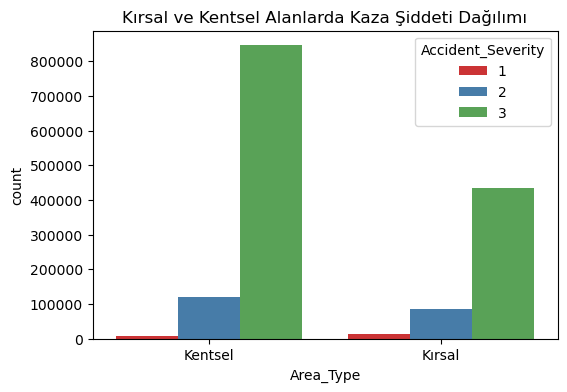

Kırsal / Kentsel Alanlara Göre Kaza Sayısı:
 Area_Type
Kentsel    972007
Kırsal     532011
Name: count, dtype: int64 



In [65]:

# 2e. Kırsal mı Kentsel mi (Urban_or_Rural_Area)
df['Area_Type'] = df['Urban_or_Rural_Area'].map({1: 'Kentsel', 2: 'Kırsal'})

plt.figure(figsize=(6,4))
sns.countplot(x='Area_Type', hue='Accident_Severity', data=df, palette='Set1')
plt.title('Kırsal ve Kentsel Alanlarda Kaza Şiddeti Dağılımı')
plt.show()
print("Kırsal / Kentsel Alanlara Göre Kaza Sayısı:\n", df['Area_Type'].value_counts(), "\n")

In [67]:
import pandas as pd
from scipy.stats import chi2_contingency

def chi2_test_categoricals(df, cat_var, target='Accident_Severity'):
    # Çapraz tablo oluştur
    contingency_table = pd.crosstab(df[cat_var], df[target])
    # Ki-kare testi uygula
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f'Ki-Kare Testi Sonuçları: {cat_var} vs {target}')
    print(f'Chi2 Statistiği: {chi2:.4f}, p-değeri: {p:.4f}')
    if p < 0.05:
        print(f'{cat_var} ile {target} arasında anlamlı ilişki var.\n')
    else:
        print(f'{cat_var} ile {target} arasında anlamlı ilişki yok.\n')

# Örnek kullanım
categorical_vars = ['Weather_Conditions', 'Road_Type', 'Urban_or_Rural_Area']

for var in categorical_vars:
    chi2_test_categoricals(df, var)


Ki-Kare Testi Sonuçları: Weather_Conditions vs Accident_Severity
Chi2 Statistiği: 1692.9818, p-değeri: 0.0000
Weather_Conditions ile Accident_Severity arasında anlamlı ilişki var.

Ki-Kare Testi Sonuçları: Road_Type vs Accident_Severity
Chi2 Statistiği: 4986.6297, p-değeri: 0.0000
Road_Type ile Accident_Severity arasında anlamlı ilişki var.

Ki-Kare Testi Sonuçları: Urban_or_Rural_Area vs Accident_Severity
Chi2 Statistiği: 11591.7266, p-değeri: 0.0000
Urban_or_Rural_Area ile Accident_Severity arasında anlamlı ilişki var.



20:56:39 - cmdstanpy - INFO - Chain [1] start processing
20:56:40 - cmdstanpy - INFO - Chain [1] done processing


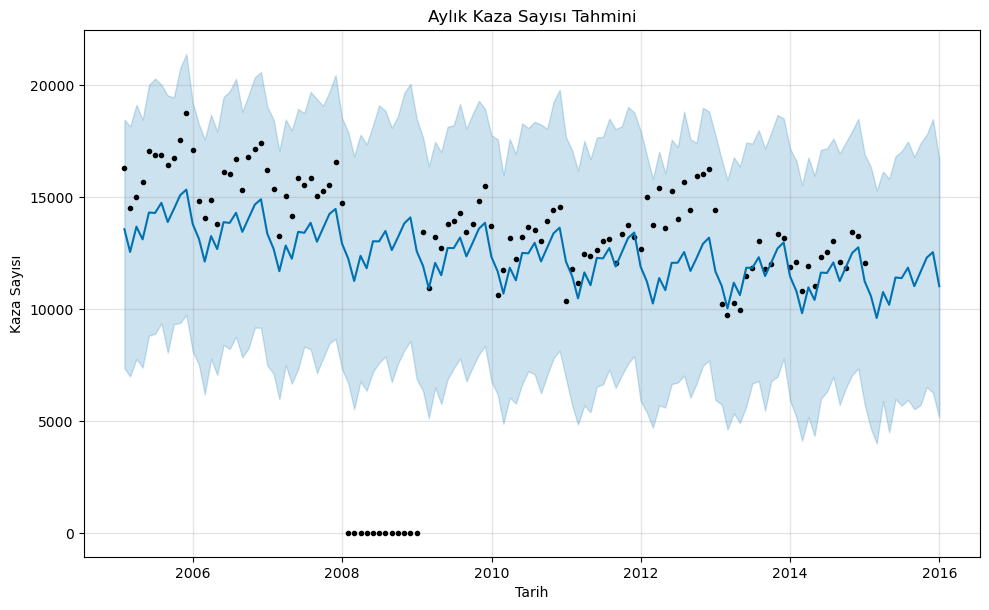

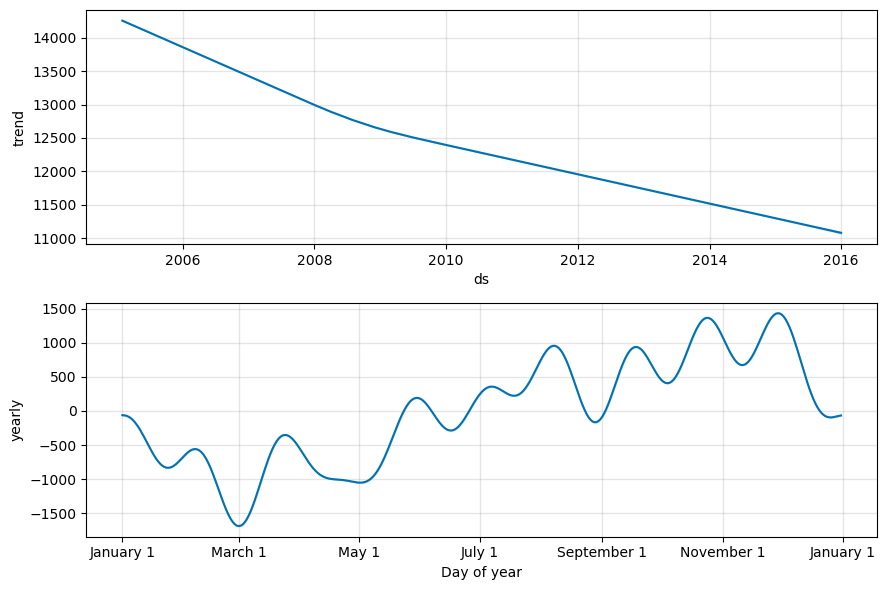

In [85]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


# Aylık kaza sayısı hesapla
df_monthly = df.groupby(pd.Grouper(key='Date', freq='M')).size().reset_index(name='count')

# Prophet için sütun isimlerini değiştir (ds: tarih, y: değer)
df_monthly.rename(columns={'Date': 'ds', 'count': 'y'}, inplace=True)

# Modeli oluştur ve eğit
model = Prophet()
model.fit(df_monthly)

# Gelecek 12 ay için tarih aralığı oluştur
future = model.make_future_dataframe(periods=12, freq='M')

# Tahmin yap
forecast = model.predict(future)

# Tahmin grafiğini çiz
fig1 = model.plot(forecast)
plt.title('Aylık Kaza Sayısı Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Kaza Sayısı')
plt.show()

# Tahmin bileşenlerini göster (trend, mevsimsellik vb)
fig2 = model.plot_components(forecast)
plt.show()


Kentsel ve Kırsal Alanlara Göre Kaza Sayıları:
Urban_or_Rural_Area
1    972007
2    532011
3       132
Name: count, dtype: int64


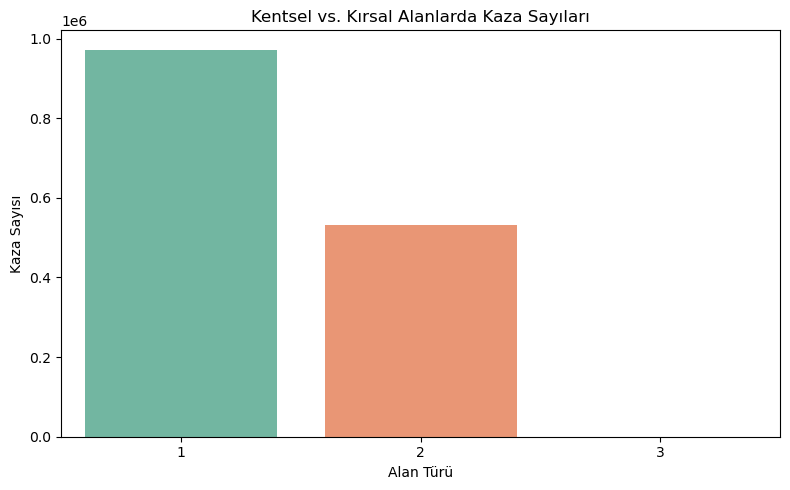

In [87]:

# Kentsel ve kırsal alanlara göre kaza sayısı
area_counts = df["Urban_or_Rural_Area"].value_counts()
print("Kentsel ve Kırsal Alanlara Göre Kaza Sayıları:")
print(area_counts)

# Görselleştirme
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Urban_or_Rural_Area", palette="Set2")
plt.title("Kentsel vs. Kırsal Alanlarda Kaza Sayıları")
plt.xlabel("Alan Türü")
plt.ylabel("Kaza Sayısı")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [89]:
df['Urban_or_Rural_Area'].value_counts().sort_index()


Urban_or_Rural_Area
1    972007
2    532011
3       132
Name: count, dtype: int64

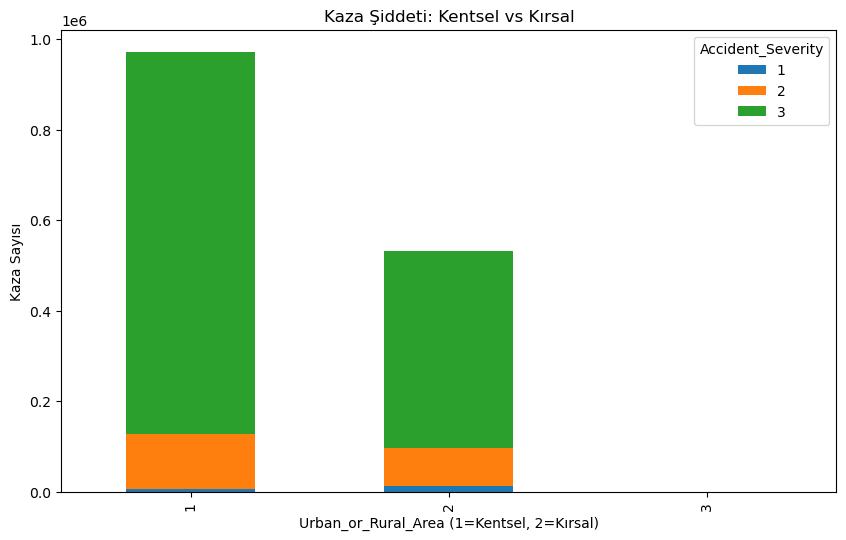

Kentsel ve Kırsal Alanlarda Kaza Şiddeti Sayıları:

Urban_or_Rural_Area  Accident_Severity
1                    1                      6943
                     2                    119632
                     3                    845432
2                    1                     12498
                     2                     84855
                     3                    434658
3                    2                        17
                     3                       115
dtype: int64


In [99]:
# Kaza şiddeti dağılımı kentsel ve kırsal için
severity_counts = df.groupby(['Urban_or_Rural_Area', 'Accident_Severity']).size().unstack()

# Grafik çizimi
ax = severity_counts.plot(kind='bar', stacked=True, figsize=(10,6), title='Kaza Şiddeti: Kentsel vs Kırsal')
ax.set_xlabel('Urban_or_Rural_Area (1=Kentsel, 2=Kırsal)')
ax.set_ylabel('Kaza Sayısı')
plt.show()

# Altına value_counts() çıktısı
print("Kentsel ve Kırsal Alanlarda Kaza Şiddeti Sayıları:\n")
print(df.groupby(['Urban_or_Rural_Area', 'Accident_Severity']).size())

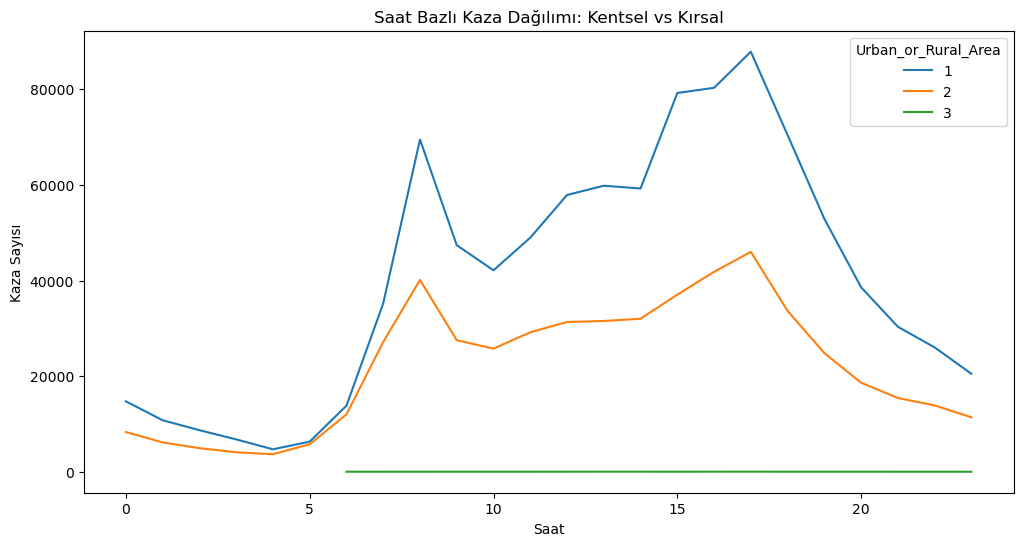

Kentsel ve Kırsal Alanlarda Saat Bazlı Kaza Sayıları:

Urban_or_Rural_Area  Hour
1                    0       14716
                     1       10761
                     2        8689
                     3        6765
                     4        4687
                             ...  
3                    19          6
                     20          8
                     21          4
                     22          4
                     23          1
Length: 68, dtype: int64


In [103]:
# Saat bazlı kaza dağılımı - kentsel ve kırsal
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df['Hour'] = df['Time'].dt.hour

ax = df.groupby(['Urban_or_Rural_Area', 'Hour']).size().unstack().T.plot(figsize=(12,6), title='Saat Bazlı Kaza Dağılımı: Kentsel vs Kırsal')
ax.set_xlabel('Saat')
ax.set_ylabel('Kaza Sayısı')
plt.show()

# Altında value_counts çıktısı
print("Kentsel ve Kırsal Alanlarda Saat Bazlı Kaza Sayıları:\n")
print(df.groupby(['Urban_or_Rural_Area', 'Hour']).size())